<a href="https://colab.research.google.com/github/dangduong2806/google-colab/blob/main/copy3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import files
uploaded = files.upload()

Saving colors1.csv to colors1.csv


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas as pd

In [20]:
df = pd.read_csv("colors1.csv")
df.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


Standardize data

In [21]:
df["red"] = df["red"] / 255
df["green"] = df["green"] / 255
df["blue"] = df["blue"] / 255
df.head()

,name,red,green,blue
0,parakeet,0.682353,0.713725,0.341176
1,saddle brown,0.345098,0.203922,0.003922
2,cucumber crush,0.870588,0.929412,0.843137
3,pool blue,0.525490,0.760784,0.788235
4,distance,0.384314,0.431373,0.509804


In [22]:
len(df["name"])

14357

Tách input và output

In [23]:
X_texts = df['name'].astype(str).values
y_rgb = df[['red', 'green', 'blue']].values

Chuyển đổi tên màu thành chuỗi số

In [24]:
vectorizer = layers.TextVectorization(output_sequence_length=5)
vectorizer.adapt(X_texts)
vocab_size = len(vectorizer.get_vocabulary())

Sử dụng mô hình Transfromer Encoder để update data

In [25]:
def transformer_encoder(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = layers.Input(shape=(None, embed_dim))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention = layers.Dropout(rate)(attention)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ffn = layers.Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.L2(1e-3))(out1)
    ffn = layers.Dense(embed_dim, kernel_regularizer=regularizers.L2(1e-3))(ffn)
    ffn = layers.Dropout(rate)(ffn)
    outputs = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return models.Model(inputs, outputs)

In [26]:
input_text = layers.Input(shape=(), dtype="string")
x = vectorizer(input_text)
x = layers.Embedding(input_dim=vocab_size, output_dim=64)(x)
x = layers.Dropout(0.2)(x)
x = transformer_encoder(embed_dim=64, num_heads=2, ff_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3, activation='sigmoid')(x)

In [27]:
model = models.Model(input_text, output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])

In [28]:
len(X_texts)

14357

Huấn luyện

In [29]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.weights.h5',  # Must end with .weights.h5
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Khởi tạo callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # theo dõi val_loss (có thể là 'val_accuracy' tùy bài toán)
    factor=0.5,              # mỗi lần giảm thì LR = LR * factor
    patience=5,              # nếu sau 5 epoch val_loss không cải thiện thì giảm LR
    min_lr=1e-6,             # learning rate nhỏ nhất có thể giảm tới
    verbose=1                # in log khi learning rate thay đổi
)

In [32]:
history = model.fit(
    X_texts,
    y_rgb,
    epochs=300,
    batch_size=16,
    validation_split=0.2,
    shuffle=True,
    callbacks= [checkpoint, reduce_lr, earlystop]
)


Epoch 1/300
715/718 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4993 - loss: 0.3792
Epoch 1: val_loss improved from inf to 0.31894, saving model to best_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4995 - loss: 0.3790 - val_accuracy: 0.6476 - val_loss: 0.3189 - learning_rate: 1.0000e-04
Epoch 2/300
714/718 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6276 - loss: 0.2913
Epoch 2: val_loss improved from 0.31894 to 0.26617, saving model to best_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6277 - loss: 0.2912 - val_accuracy: 0.6835 - val_loss: 0.2662 - learning_rate: 1.0000e-04
Epoch 3/300
713/718 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6576 - loss: 0.2416
Epoch 3: val_loss improved from 0.26617 to 0.24027, saving model to best_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6577 - loss: 0.2416 - val_accuracy: 0.7145 - val_loss: 0.2403 - learning_rate: 1.0000e-04
Epoch 4/300
715/718 ━━━━━━━━━━━━━━━

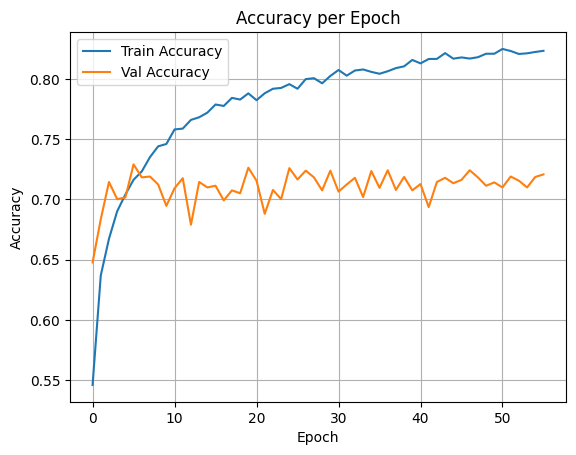

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
model.load_weights('best_model.weights.h5')

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb, test_size=0.2, random_state=42
)

In [39]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f"Best model val_accuracy: {val_acc:.4f}")
print(f"Best model val_loss:     {val_loss:.4f}")

Best model val_accuracy: 0.8242
Best model val_loss:     0.0819


In [40]:
from google.colab import files
uploaded = files.upload()

Saving adj.txt to adj.txt


In [41]:
def generate_color_names():
    with open('adj.txt', 'r') as file:
        adjectives = file.read().splitlines()

    colors = ["Red", "Yellow", "Blue", "Orange", "Green", "Violet", "Pink", "Black", "White", "Brown", "Grey"]

    for adjective in adjectives:
        for color in colors:
            yield f"{adjective} {color}"

In [42]:
def scale(n):
    return int(n * 255)

In [43]:
data = pd.read_csv("colors1.csv")
data.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


In [81]:
path = "updated_colors.csv"
def predict_and_update(name):
    global data, path

    name = name.lower()

    tokens = vectorizer([name])
    tokens = tf.strings.as_string(tokens)
    tokens = tf.reshape(tokens, [-1])

    # Dự đoán RGB
    pred = model.predict(tokens)[0]  # Lấy mảng đầu tiên nếu batch_size = 1

    # Scale về 0-255
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])

    # Thêm dòng mới vào DataFrame
    data.loc[len(data)] = [name, r, g, b]

    # Ghi đè CSV
    path = "updated_colors.csv"
    data.to_csv(path, index=False)


In [ ]:
for color_name in generate_color_names():
    predict_and_update(color_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━